In [5]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import xarray as xr
import pandas as pd

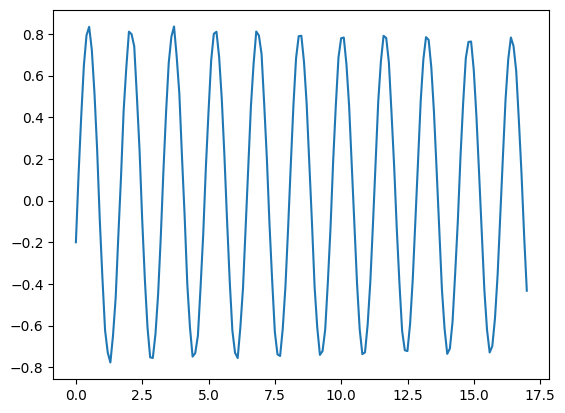

In [111]:
df=pd.read_csv('RawData_down_sampled_500_2200_10.csv',header=0,names=['t','a_x','a_y','a_z','a'])
t=df['t'].to_numpy()
a_x=df['a_x'].to_numpy()
t=t-t[0]
plt.plot(t,a_x)

## INTRODUCTION
Bayes' Theorem:

$ P(\theta | x) = \dfrac{P(x | \theta)P(\theta)}{P(x)}$

Here, the terms in the equation are:

$P(x|\theta) = $ Likelihood: the probability of observing the data given the parameters. This quantifies how likely we are to have obtained the measurements that we do have, given that the model is described by the parameters $\theta$

$P(\theta) = $ Prior: a measure of our "prior" belief in the values of the parameter $\theta$. 

$P(x) = $ Evidence for the data


## Choosing the right prior

In Bayesian probability, parameters are not fixed values, but random variables that follow a probability distribution. 
TO-DO: Add basic info. on Bayesian and Frequentist approaches to probability. 

Priors encode our existing knowledge of the parameter we wish to measure. For the simple pendulum, consider the following sinusoidal model - 

$$ x = A e^{-\beta t} \sin (\omega t + \phi) $$

Here, the parameters we wish to infer are the amplitude $A$, the damping factor $\beta$, the frequency $\omega$ and the phase angle $\delta$. 

## Choice of Priors for the pendulum 

TO-DO: Elaborate more on choice of functions.
- Amplitude: Uniform distribution in $[0,1]$
- $\beta$: Truncated normal distribution
- $f = \omega/2\pi$ : Truncated normal distribution
- $\phi$: Von-Mises distribution (this is circular in $[-\pi,\pi]$ and ideal for periodic values such as phases.

Finally, we model the uncertainty in our measure of $x$ with Gaussian noise `sigma`. 

In [113]:
with pm.Model() as model:
    amplt = pm.Uniform('amplt', lower=0.,upper=1.)
    beta = pm.TruncatedNormal('beta',mu=0.1,sigma=0.01,lower=0.)
    freq = pm.TruncatedNormal('freq',mu=1.,sigma=1.,lower=0.)
    phase = pm.VonMises('phase',mu=0.,kappa=np.pi/6)
    mu_x = amplt*pm.math.exp(-beta*t)*pm.math.cos(2*np.pi * t * freq + phase) # Construct x as a function of the parameters
    sigma = pm.Normal('sigma',mu=0.,sigma=1.) # Model the measurement uncertainty as a Gaussian
    X_obs = pm.Normal('X_obs', mu=mu_x, sigma=sigma, observed=a_x) # construct the likelihood term as a Gaussian
    trace = pm.sample(1000,tune=500) # Now draw 1000 samples from 
    trace_post=pm.sample_posterior_predictive(trace,var_names=['X_obs','freq','phase'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [amplt, beta, freq, phase, sigma]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
Sampling: [X_obs, freq, phase]


## Note on PyMC

There are two kinds of "variables" in PyMC - stochastic and deterministic. 

In the above code block, `amplt`, `beta`, `freq` and `phase` are stochastic variables, meaning they are sampled from the priors that we have chosen. 

`mu_x` is a deterministic variable, which means that its value is completely determined by that of its parents (which are the stochastic variables above).

`X_obs` is a special case, called an observed stochastic variable. It represents the likelihood of the model given the data, which is represented by the $P(X|\theta)$ term in Bayes' Theorem. It is defined in an identical manner to an ordinary stochastic variable in PyMC, except for the `observed =` argument, which indicates that these values for the variable have been observed and should not be modified by the fitting algorithm. Here, we pass our values that we recorded using the mobile phone sensor. 

So you will note here that the parameters for `X_obs` are not fixed as they were for the priors, but are given by the deterministic variable `mu` and the stochastic variable `sigma`. 

Now that the priors and the likelihood are defined, we call `pm.sample()`, which draws samples from the posterior using the NUTS sampler. 

TO-DO: Add some text on MCMC and Bayesian Inference

Finally, call the `sample_posterior_predictive()` method to generate posterior predictive samples of the parameters given the posterior distributions passed to it through the object `trace`.

## Prelimary Plots

We use the `arviz` library for post-processing and diagnostics. Call `plot_trace` to view the posterior distributions of the parameters.  

Before that, define the acceleration due to gravity `g` using the formula:
$$ g = 4\pi^2 f^2 L $$

where $L=0.6285m$

array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'amplt'}>,
        <Axes: title={'center': 'amplt'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'freq'}>,
        <Axes: title={'center': 'freq'}>],
       [<Axes: title={'center': 'phase'}>,
        <Axes: title={'center': 'phase'}>],
       [<Axes: title={'center': 'g'}>, <Axes: title={'center': 'g'}>]],
      dtype=object)

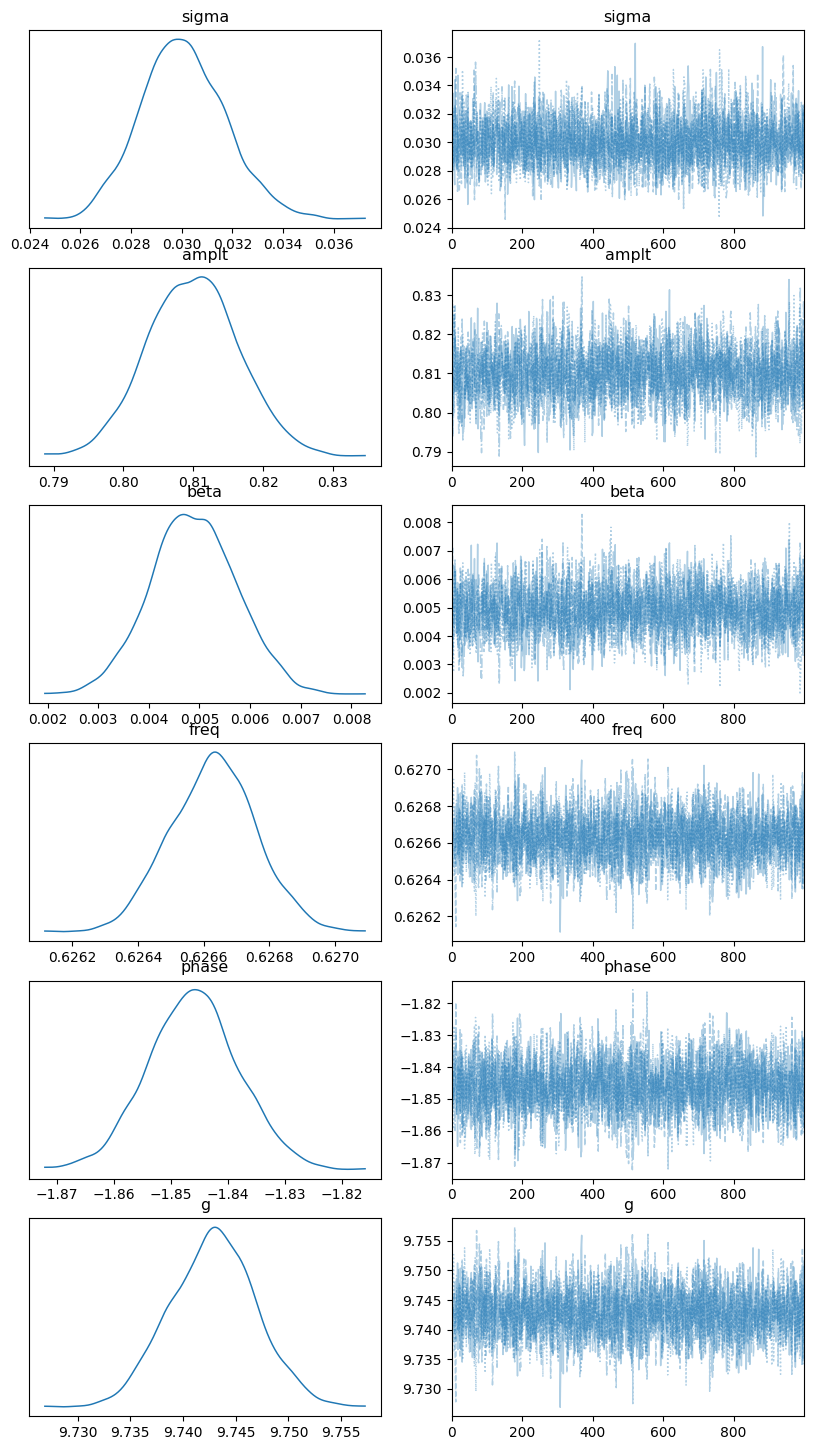

In [124]:
#fig,ax=plt.subplots(figsize=(10,15))
trace.posterior['g']=4*np.pi**2 * trace.posterior['freq']**2 *0.6285
az.plot_trace(trace,combined=True,figsize=(10,18))

## Viewing summaries

Call the `summary()` method to view a summary of the inferred parameters

In [195]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.030,0.002,0.027,0.033,0.0,0.0,3106.0,2329.0,1.0
amplt,0.810,0.007,0.797,0.822,0.0,0.0,2192.0,2237.0,1.0
beta,0.005,0.001,0.003,0.006,0.0,0.0,2243.0,2087.0,1.0
freq,0.627,0.000,0.626,0.627,0.0,0.0,2824.0,2454.0,1.0
phase,-1.846,0.008,-1.861,-1.831,0.0,0.0,2864.0,2472.0,1.0
g,9.743,0.004,9.735,9.750,0.0,0.0,2824.0,2454.0,1.0


In [92]:
trace.posterior["y_model"] = trace.posterior['amplt']*np.exp(-trace.posterior['beta']*xr.DataArray(t))*np.cos(2*np.pi*trace.posterior["freq"]*xr.DataArray(t)+trace.posterior['phase'])

## Predicting the mean position of the pendulum
Using the samples that we generated from the posterior distribution, we predict the mean position of the pendulum at a given time by averaging over the number of draws and the number of chains (`n_chains` by default is set equal to the number of cores in the machine, can be set to any other number)

In [196]:
mean_obs = (
    trace_post.posterior_predictive["X_obs"]
    .stack(samples=("chain", "draw"))
    .mean(axis=1)
)
hdi_data=az.hdi(trace_post.posterior_predictive['X_obs'],hdi_prob=0.95) # Construct the 95% credible interval (hdi=highest density interval)
hdi_data=hdi_data['X_obs']

## Plotting

Plot the results with the $95\%$ credible interval, which we created using the `hdi()` method of Arviz. The observed data can also be recovered from the `trace_post` object and plotted on the same canvas.

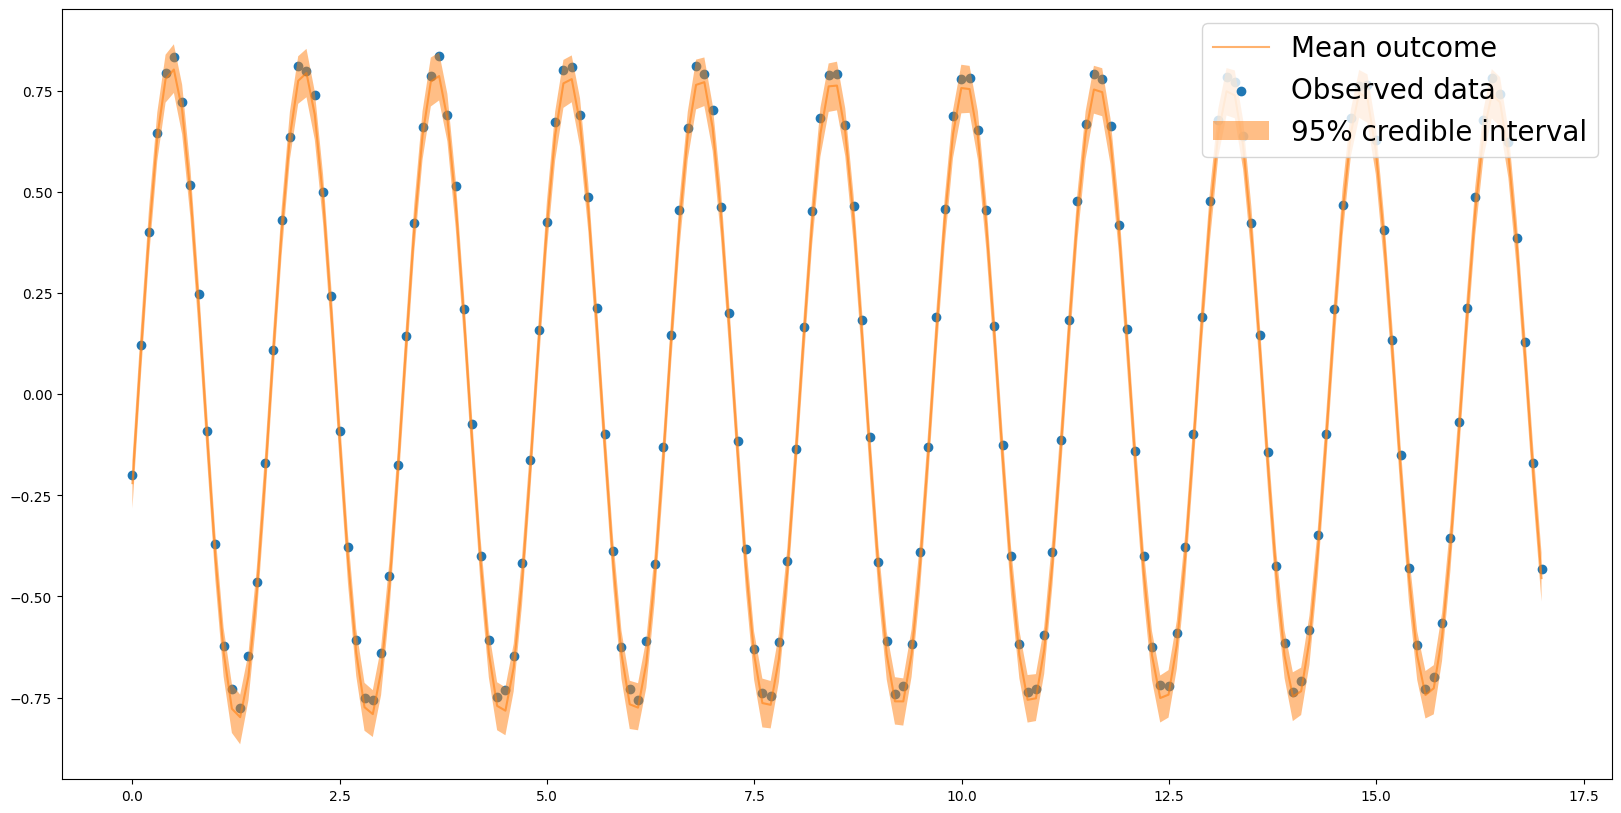

In [131]:
fig,ax=plt.subplots(figsize=(20,10))
ax.plot(t, mean_obs, label="Mean outcome", color="C1", alpha=0.6)
ax.scatter(t, trace_post.observed_data["X_obs"],label='Observed data')
#az.plot_hdi(t, hdi_data=hdi_data,ax=ax)
ax.fill_between(t,hdi_data[:,1],hdi_data[:,0],label='95% credible interval',alpha=0.5)
ax.legend(loc='upper right',fontsize=20)


## Results

In [200]:
g_lims=np.asarray(az.hdi(trace,var_names=['g'],hdi_prob=0.95)['g'])
g_mean=az.summary(trace,var_names=['g'])['mean'][0]
g_lims=np.round(g_lims-g_mean,3)

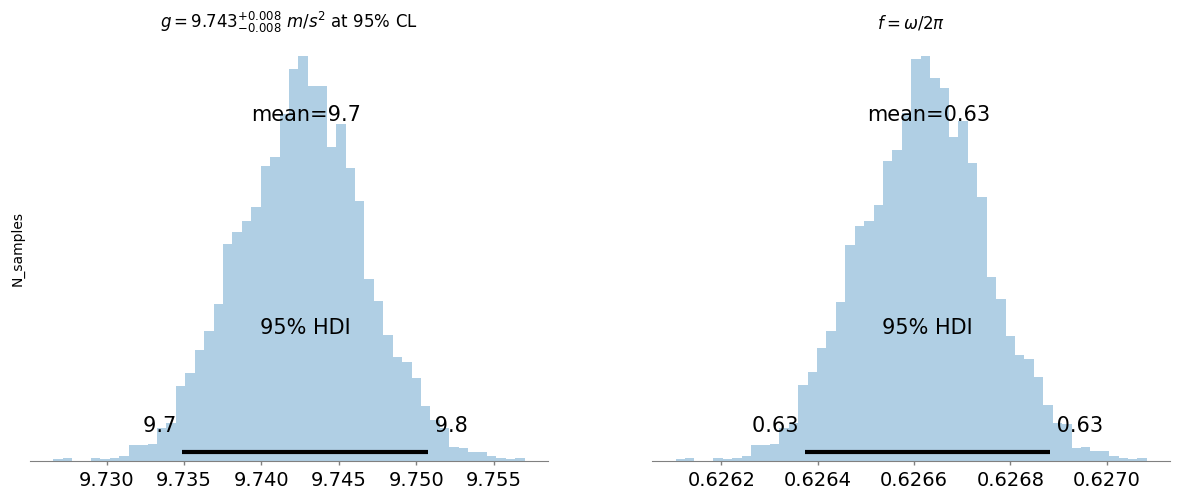

In [201]:
ax=az.plot_posterior(trace,var_names=['g','freq'],hdi_prob=0.95,kind='hist',bins=50)
ax[0].set_ylabel('N_samples')
ax[0].set_title(f'$g={g_mean}_{{{g_lims[0]}}}^{{+{g_lims[1]}}}$ $m/s^{2}$ at 95% CL')
ax[1].set_title('$f=\omega/2\pi$')
ax[0].get_yaxis().set_visible(True)
